> ## GERMAN CREDIT DATASET ÜZERİNDE ÖZELLİK MÜHENDİSLİĞİ & VERİ ÖN İŞLEME

### ****Veri Ön İşleme, veriden daha sağlıklı sonuçların çıkarılmasını sağlayan bir veri temizleme yöntemidir.Verinin bir modele girebilmesi için yapılan hazırlıktır.Aykırı ve gürültülü değerlerden veriyi temizlemek için uygulanır.****

Kullanılan data bir banka datasıdır, hedef değişkeni risk olup gözlemlerin bazı parametrelere göre kredilerini ödeyip ödeyememe risklerini anlatır.Risk değişkeni 'good' ise riskli değil 'bad' ise riskli olduğunu belirtir.

* Gerekli kütüphanelerin import edilmesi

In [ ]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)

* Verinin okutulması

In [ ]:
dff=pd.read_csv("../input/german-credit-data-with-risk/german_credit_data.csv")

* Son aşamada veri ön işleme yapılmadan veriyi modele katıp farkı görmek için burada veriyi kopyalıyoruz.

In [ ]:
df=dff.copy()

* İlk 5 satırı görüntüleme

In [ ]:
df.head()

* Gereksiz bir column var indexle aynı o yüzden onu siliyoruz

In [ ]:
df.drop("Unnamed: 0",axis=1,inplace=True)

### 1-Aykırı değerlerin belirlenmesi

In [ ]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.80)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

In [ ]:
up

In [ ]:
low

* Aykırı değerlerin listelenmesi

In [ ]:
df[(df["Age"] < low) | (df["Age"] > up)]

* Satırda veya sütunda aykırı değer var mı sorusunun cevabını döndürüyor

In [ ]:
df[(df["Age"] > up) | (df["Age"] < low)].any(axis=None)

### 2-Aykırı değerleri belirlediğimiz çeyreklikteki değerlere baskılıyoruz.Yani 0'dan küçük age değeri varsa onlara 0 atıyoruz aynı şekilde 72'den büyük bir değer varsa da onları 72'ye eşitliyoruz bu şekilde aykırı değerler baskılanıyor.

In [ ]:
df.loc[df["Age"] < low,"Age"]=low

In [ ]:
df.loc[df["Age"] > up,"Age"]=up

* Aykırı değer kontrolü yapıyoruz, baskılama işlemimiz sorunsuz gerçekleşmiş mi diye.
* False dönmesini bekliyoruz.

In [ ]:
df[(df["Age"] > up) | (df["Age"] < low)].any(axis=None)

### 3-Eksik değer sorunu ve null değerlerin doldurulması

* Dataframedeki columnlara göre toplam boş değer sayısı

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

* Kategorik değişkenlerde eksik değer olduğundan tipi object olan ve eşşiz sınıf sayısı 10'dan küçük olanların boş değerlerini mode'larıyla dolduruyoruz.

In [ ]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [ ]:
df.head()

In [ ]:
df.info()

* Age değerlerini integer'a çeviriyorum.

In [ ]:
df["Age"]=[int(i) for i in df["Age"]]

* Eksik değer sorunu çözülmüş mü kontrol ediyorum.

In [ ]:
df.isnull().sum()

In [ ]:
df["Age"].describe()

* Age değişkenini belirlediğim quantile değerlerine göre kategorize ediyorum; genç,yetişkin,yaşlı olarak.

In [ ]:
q25 = df["Age"].quantile(0.25)
q90 = df["Age"].quantile(0.90)

In [ ]:
q25

In [ ]:
q90

In [ ]:
df.loc[df["Age"]< q25,"new_age"]="young"

In [ ]:
df.loc[(df["Age"] >= q25) & (df["Age"]< q90),"new_age"]="mature"

In [ ]:
df.loc[(df["Age"] >= q90),"new_age"]="senior"

* İkili değerlere göre risk durumunu kontrol etmek istediğimden ve bunları teker teker yazmak zor olacağından fonksiyon yazıyorum.

In [ ]:
def twice_col(df,col1,col2):
    n=df[col1].unique().tolist()
    l=len(n)
    n1=df[col2].unique().tolist()
    l1=len(n1)
    for i in n:
        for j in range(l):
            for z in n1:
                for t in range(l1):
                    df.loc[(df[col1] == n[j]) & (df[col2] == n1[t]), str(col1) + "_" + str(col2)]=str(n[j]) +"_"+ str(n1[t])
        

In [ ]:
twice_col(df,"new_age","Sex")

In [ ]:
twice_col(df,"Sex","Housing")

In [ ]:
twice_col(df,'new_age',"Housing")

In [ ]:
twice_col(df,"Job","Housing")

* Job değişkenine ait frekansları saydırıyorum, 4 unique değer olduğunu görüyorum.Herhangi bir işlem yapmamıza gerek yok.

In [ ]:
df["Job"].value_counts()

* Kredi ödeme sürelerinde de fazla unique değer olduğundan model için 4 kategoriye ayıralım.

In [ ]:
df["Duration"].unique()

In [ ]:
df["Duration"].describe().T

In [ ]:
df.loc[df["Duration"] < 18,"new_duration"]= "A"
df.loc[(df["Duration"] >= 18) & (df["Duration"] <30),"new_duration"]= "B"
df.loc[(df["Duration"] >= 30) & (df["Duration"] <48),"new_duration"]= "C"
df.loc[df["Duration"] >= 48,"new_duration"]= "D"

In [ ]:
df.head()

In [ ]:
df["Credit amount"].describe().T

* Kredi ödeme miktarlarında da aynı şekilde birçok unique değer olduğundan kategorize ediyorum.

In [ ]:
q25 = df["Credit amount"].quantile(0.25)
q50 = df["Credit amount"].quantile(0.50)
q75 = df["Credit amount"].quantile(0.75)

In [ ]:
df.loc[(df["Credit amount"] < q25),"new_Credit_amount"]="A"

In [ ]:
df.loc[(df["Credit amount"] >= q25) & (df["Duration"] < q50),"new_Credit_amount"]= "B"

In [ ]:
df.loc[(df["Credit amount"] >= q50) & (df["Duration"] < q75),"new_Credit_amount"]= "C"

In [ ]:
df.loc[(df["Credit amount"] >= q75),"new_Credit_amount"]= "D"

In [ ]:
df.head()

In [ ]:
df["Risk"].unique()

### 4-Encoding

* Label encoder, kategorik değişkenleri numerik değişkenlere dönüştürmemizi sağlayan metottur.Risk de yukarıda görüldüğü gibi good ve bad olarak kategorize edilmiş bu yüzden 0 ve 1'e çevireceğiz.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
labelencoder = LabelEncoder()
df["Risk"] = labelencoder.fit_transform(df["Risk"])

In [ ]:
df.head()

* Oluşturduğumuz kategorilere göre risk ortalamasına bakmak istiyoruz, bunun için aşağıdaki gibi bir fonksiyon oluşturdum.

In [ ]:
def meann(df,b):
    a={}
    for i in b:
        a[i]=df.groupby(i)["Risk"].mean()
        c=print(a,"/n")
    return c   

In [ ]:
b=['Sex_Housing','new_age_Housing','Job_Housing','new_age_Sex']

In [ ]:
#0 riskli olma durumu 1 olmama durumunu ifade ediyor.
#Örneğin female_free(kadın ve evsiz)'nin risk durumu yüksek mantıken kredisini de ödeyememesini bekleriz 
#female_own ise(kendi evi olan ve kadın) 'nın 1'e daha yakın yani kendi evi olan birinin
# kredisini ödemesini bekleriz
meann(df,b)

* Model için kategorik,numerik ve kategorik görünen fakat kardinal olan column'ları getiriyoruz.

In [ ]:
cat_cols, num_cols, cat_but_car=grab_col_names(df, cat_th=10, car_th=20)

In [ ]:
cat_cols

In [ ]:
num_cols

In [ ]:
cat_but_car

* Burada ise tüm columnlarda gezilmesini, iki eşsiz sınıfa sahip olan ama int ve float olmayan columnları döndürmesini istiyoruz.Dönen columnlar kategorik olduğundan da label encoder ile numerik'e çeviriyoruz.

In [ ]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

In [ ]:
binary_cols

In [ ]:
df.head()

* Rare analyser fonksiyonu ile girilen dataframe,target ve kategorik columns parametrelerinin dataframe'deki sayısını, o column'daki değerlerin sayısının toplam dataframe sayısına oranını ve columnlara göre groupby yapıldığında target değişkeninin(Risk) ortalamasını bize döndürür.

In [ ]:
rare_analyser(df, "Risk", cat_cols)
#male:1 female:0 
#Bu dataframede male'den 310 gözlem female'den 690 gözlem vardır. Oranları 310/1000'den 0.31,
# 690/1000'den 0.69'dur.Ve erkeklerin risk durumu kadınlarınkinden daha yüksektir.
#Devamı da bu şekilde yorumlanabilir.

* Rare encoder fonksiyonu  kendisine parametre olarak girilen dataframe ve oranla ilgili işlem yapıyor, girilen oran parametresini alt sınır kabul edip o sınırın altındakileri rare olarak adlandırıyor ve adlandırılan birçok değişken olursa hepsi rare olduğundan oranları ve sayıları toplanıyor.Kısacası diğer olarak döndürülüyor. Dataframede az sayıda gözlemlendiğinden tek tek değerlendirip modeli de kendimizi de yormuyoruz.

In [ ]:
df = rare_encoder(df, 0.05)

* Rare değişkenlerimizi aşağıda görebilirsiniz.

In [ ]:
rare_analyser(df, "Risk", cat_cols)

* One hot encoder yine bir kategorik değişkenleri numerik'e dönüştürme yöntemidir.Kaç değişken döndürülecekse n-1 kadar column ile matrix oluşturulur.Örneğin;

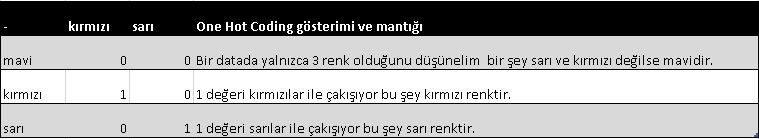

In [ ]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [ ]:
ohe_cols

In [ ]:
#one_hot_encoder
df= pd.get_dummies(df,ohe_cols, drop_first=False)

In [ ]:
df=one_hot_encoder(df, ohe_cols)

In [ ]:
df.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 5-Standartlaştırma

* Şimdi ise numerik değerlerimizi standartlaştıracağız çünkü modele girerken bu işlemi yapmamız gerekir.Standartlaştırma, verileri belli bir sayı arasında oranlamaktır yani verileri aynı ölçeğe indirger.

In [ ]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

In [ ]:
df.head()

### 6-Modelleme

* Veri ön işlemesini bitirdiğimiz veriyi modele katıyoruz.

In [ ]:
y = df["Risk"]
X = df.drop("Risk",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

* Modelin ön işlemesini yaptığımız parametrelere göre hedef değişkeni tahmin etme oranı %70.5 'miş gayet iyi.

* Şimdi ise veri ön işlemenin önemini çok daha iyi anlayabilmek için veri ön işleme yapmadığımız yani verinin ilk okutulduğu halini modele katıyoruz.

In [ ]:
dff.dropna(inplace=True)

In [ ]:
dff = pd.get_dummies(dff, columns=["Sex"], drop_first=True)

In [ ]:
y = dff["Risk"]
X = dff.drop(["Unnamed: 0","Risk","Housing","Saving accounts","Checking account","Purpose"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

Görüldüğü üzere tahmin başarımız ön işleme yapılmadan %58.0 iken ön işleme yaptığımızda %70.5'e çıkmış.
Kısacası veri ön işleme işlemi ne kadar iyi yapılırsa veriden o kadar anlamlı sonuçlar elde ederiz.
Veri ön işleme hayat kurtarır :))
Görüşmek üzeerreeee :))